# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [1]:
## The following libraries might be useful
!pip install -U -q langchain-community
!pip install -U -q datasets
!pip install -U -q ragas
!pip install -U -q rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-c

In [2]:
# Import essential libraries
import os
import json
import re
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

#from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
#from langchain_openai import ChatOpenAI
#from langchain_openai import OpenAIEmbeddings

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [3]:
# Load the files as documents

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your shared folder
folder_path = "/content/drive/MyDrive/rag_legal/corpus"

# Walk through subfolders and load all .txt files using LangChain
documents = []
for root, _, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".txt"):
            full_path = os.path.join(root, file)
            loader = TextLoader(full_path, encoding='utf-8')
            docs = loader.load()

            for doc in docs:
                category = os.path.basename(os.path.dirname(full_path))
                doc.metadata['filename'] = file
                doc.metadata['dir'] = root
                doc.metadata['category'] = category # assigning foldername as category
                documents.append(doc)

print(f"Loaded {len(documents)} documents.")

Mounted at /content/drive
Loaded 698 documents.


#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [4]:
# Clean and preprocess the data

# Preprocessing Function with Logging and Metadata
import re
import logging
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt_tab')
nltk.download("punkt")
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

# Setup error logger
logging.basicConfig(filename="preprocessing_errors.log", level=logging.ERROR)

def clean_text(text):
    try:
        # Insert space between lower-uppercase like: "infoWe" → "info We"
        #text = re.sub(r"(?<=[a-z])(?=[A-Z])", " ", text)

        # Normalize
        text = text.lower()

        # Remove emails and phone numbers
        text = re.sub(r'\S+@\S+', '', text)  # Email
        text = re.sub(r'\\+?\d[\d\s().-]{7,}', '', text)  # Phone numbers

        # Remove special characters not digits (keep letters, digits and space)
        #text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Remove stopwords
        tokens = word_tokenize(text)
        filtered = [w for w in tokens if w not in stop_words]

        return ' '.join(filtered)
    except Exception as e:
        logging.error(f"Failed to clean text: {e}")
        return None

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Apply Preprocessing to All Loaded Files

preprocessed_docs = []

for doc in documents:
    try:
        if isinstance(doc, dict):  # Manual reading case
            raw_text = doc['text']
            meta = doc['metadata']
        else:  # LangChain document case
            raw_text = doc.page_content
            meta = doc.metadata

        cleaned = clean_text(raw_text)

        if cleaned:
            preprocessed_docs.append({
                'clean_text': cleaned,
                'metadata': meta
            })
    except Exception as e:
        logging.error(f"Error processing file {meta.get('filename', 'unknown')}: {str(e)}")
        continue

print(f"Preprocessed {len(preprocessed_docs)} documents.")

Preprocessed 698 documents.


In [6]:
preprocessed_docs[0]

{'clean_text': 'start sharing good vibes important understand using services allow us collect use disclose retain personal information information never read listen content sharing privately sure use information described policy using service also agreeing ourterms use please make sure read agree terms use want use viber first want assured read listen content messages calls made privately via viber store messages delivered destination average takes less one second reason message wasnt delivered destination within 2 weeks deleted servers note chats bots public accounts communities end end encrypted encrypt messages sent viber servers sent viber servers third party public account owner additional third party tool eg crm solution integrated owner collect minimum information required achieve purposes set policy see ability limit collection specified choices registration account information use various services voluntarily give us personal information eg name email birth date age phone numb

### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [7]:
# Calculate the average, maximum and minimum document length.

# Calculate word counts
for doc in preprocessed_docs:
    doc['word_count'] = len(doc['clean_text'].split())

# Extract word counts
word_counts = [doc['word_count'] for doc in preprocessed_docs]

# Compute statistics
avg_len = sum(word_counts) / len(word_counts)
max_len = max(word_counts)
min_len = min(word_counts)

print(f"Document Length Statistics:")
print(f"Average Length: {avg_len:.2f} letters")
print(f"Maximum Length: {max_len} letters")
print(f"Minimum Length: {min_len} letters")

Document Length Statistics:
Average Length: 9304.14 letters
Maximum Length: 87541 letters
Minimum Length: 152 letters


In [8]:
min_len

152

In [9]:
# Sort by word count
sorted_docs = sorted(preprocessed_docs, key=lambda x: x['word_count'])

# Get document with min length
min_doc = sorted_docs[0]

# Get document with max length
max_doc = sorted_docs[-1]

# Print metadata and preview of content
print("Document with MINIMUM length:")
print("Category:", min_doc['metadata'].get('category', 'unknown'))
print("Filename:", min_doc['metadata'].get('filename', 'unknown'))
print("Word Count:", min_doc['word_count'])
print("Preview:", min_doc['clean_text'][:300], "...")

print("\nDocument with MAXIMUM length:")
print("Category:", max_doc['metadata'].get('category', 'unknown'))
print("Filename:", max_doc['metadata'].get('filename', 'unknown'))
print("Word Count:", max_doc['word_count'])
print("Preview:", max_doc['clean_text'][:300], "...")

Document with MINIMUM length:
Category: cuad
Filename: GALACTICOMMTECHNOLOGIESINC_11_07_1997-EX-10.46-WEB HOSTING AGREEMENT.txt
Word Count: 152
Preview: exhibit 10 46 web hosting agreement agreement shall void nullify previous agreements date galacticomm horst entertainment inc shall additional fees kind paid galaticomm stated within agreement software usage bandwidth usage horst entertainment agrees pay galactcomm 0 01 one cent per access 400 000 a ...

Document with MAXIMUM length:
Category: maud
Filename: Contango_Oil_&_Gas_KKR_&_Co.txt
Word Count: 87541
Preview: exhibit 2 1 execution version transaction agreement dated june 7 2021 among contango oil gas company independence energy llc ie opco llc ie pubco inc ie l merger sub llc ie c merger sub inc table contents page article certain definitions 3 1 1 certain definitions 3 1 2 terms defined elsewhere 3 arti ...


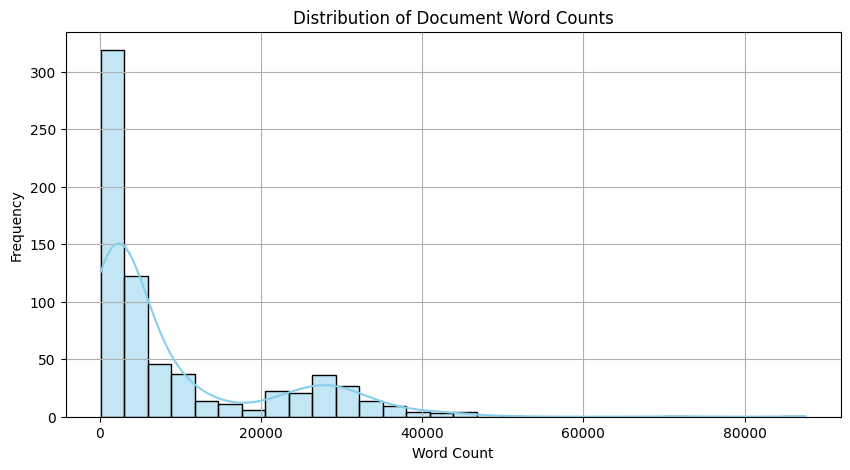

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract word counts
word_counts = [doc['word_count'] for doc in preprocessed_docs]

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(word_counts, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Document Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [11]:
# Find frequency of occurence of words

from collections import Counter
from nltk.tokenize import word_tokenize

# Combine all cleaned text
all_text = " ".join([doc['clean_text'] for doc in preprocessed_docs])

# Tokenize and filter out stopwords
stop_words = set(stopwords.words("english"))
tokens = word_tokenize(all_text)
filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

# Count word frequencies
word_freq = Counter(filtered_tokens)

In [12]:
# 20 most common words
most_common = word_freq.most_common(20)

# 20 least common (words with frequency 1)
least_common = [(word, count) for word, count in word_freq.items() if count == 1][:20]

print("20 Most Common Words:")
for word, count in most_common:
    print(f"{word}: {count}")

print("\n20 Least Common Words:")
for word, count in least_common:
    print(f"{word}: {count}")

20 Most Common Words:
company: 156422
shall: 108016
agreement: 104655
section: 75413
parent: 60715
party: 54217
date: 39392
time: 35827
material: 34242
merger: 33907
b: 33658
subsidiaries: 33320
applicable: 31384
including: 29406
respect: 28849
may: 28116
stock: 26887
information: 25725
parties: 24641
business: 23705

20 Least Common Words:
wasnt: 1
theyre: 1
andstored: 1
messaged: 1
vibe: 1
liked: 1
wps: 1
useviber: 1
macos: 1
ipads: 1
amessage: 1
admins: 1
really: 1
everybody: 1
viberapps: 1
smile: 1
appmay: 1
policyand: 1
legitimize: 1
bcr: 1


#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

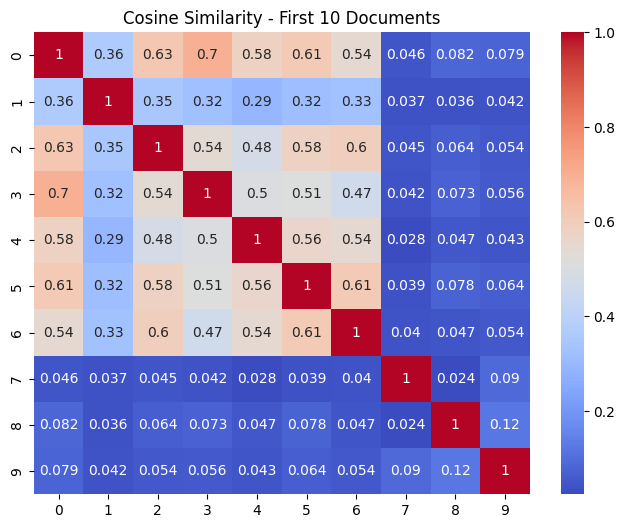

In [13]:
# Transform the page contents of documents

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract clean texts
texts = [doc["clean_text"] for doc in preprocessed_docs]

# Fit TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(texts)

# Compute similarity scores

# Similarity matrix for first 10 documents
similarity_first10 = cosine_similarity(tfidf_matrix[:10])

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_first10, annot=True, cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
plt.title("Cosine Similarity - First 10 Documents")
plt.show()

In [14]:
# create a list of 10 random integers

# Select 10 random indices
random_indices = random.sample(range(len(texts)), 10)

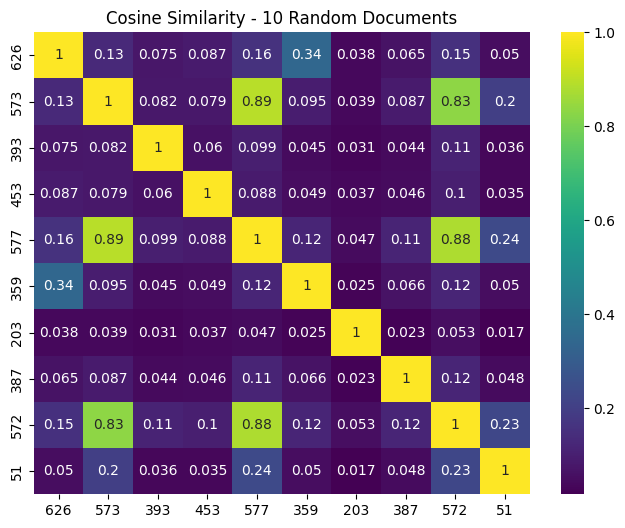

In [15]:
# Compute similarity scores for 10 random documents

tfidf_sample = tfidf_matrix[random_indices]
similarity_random10 = cosine_similarity(tfidf_sample)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_random10, annot=True, cmap="viridis", xticklabels=random_indices, yticklabels=random_indices)
plt.title("Cosine Similarity - 10 Random Documents")
plt.show()

High similarity (values near 1.0) indicates duplicate or very similar clauses (common in legal contracts).

Diagonal = 1.0 (self-similarity).

There are clusters of similar documents, e.g., all NDAs might be similar to each other.

Clusters of high values suggest reused or boilerplate text — useful for detecting redundancy.

**Random documents** are **less likely to show high similarity** unless they happen to be from the same subfolder or topic.

There are **higher number of similarity scores** observed between the **first 10 documents** than the first 10 random documents as the first 10 documents are possibly from the **same folder**.

In [16]:
# Pick a random index from the selected ones to check folder name
selected_i = 3
doc_index = random_indices[selected_i]

# Retrieve the document
doc = preprocessed_docs[doc_index]

# Print info and a content preview
print("📄 Selected Document:")
print("Index in corpus:", doc_index)
print("Category:", doc['metadata'].get('category', 'unknown'))
print("Filename:", doc['metadata'].get('filename', 'unknown'))
print("Word Count:", doc['word_count'])
print("\nContent Preview:\n")
print(doc['clean_text'][:1000], "...")  # print first 1000 chars

📄 Selected Document:
Index in corpus: 453
Category: cuad
Filename: KitovPharmaLtd_20190326_20-F_EX-4.15_11584449_EX-4.15_Manufacturing Agreement.txt
Word Count: 5481

Content Preview:

exhibit 4 15 symbol denotes places portions document omitted pursuant request confidential treatment material filed separately securities exchange commission product manufacturing agreement product manufacturing agreement agreement made effective date dexcel ltd registered address israel dexcel kitov pharma ltd registered office 132 menachem begin road azrieli center tel aviv 6701101 israel kitov dexcel kitov hereinafter jointly parties individually party whereas dexcel pharmaceutical company engaged various activities including limited research development manufacture marketing various drugs pharmaceutical specialties various dosage forms whereas kitov pharmaceutical company engaged various activities including limited development pharmaceutical products whereas kitov dexcel entered development services

In [17]:
# Pick a random index from the selected ones to check folder name
selected_i = 4
doc_index = random_indices[selected_i]

# Retrieve the document
doc = preprocessed_docs[doc_index]

# Print info and a content preview
print("📄 Selected Document:")
print("Index in corpus:", doc_index)
print("Category:", doc['metadata'].get('category', 'unknown'))
print("Filename:", doc['metadata'].get('filename', 'unknown'))
print("Word Count:", doc['word_count'])
print("\nContent Preview:\n")
print(doc['clean_text'][:1000], "...")  # print first 1000 chars

📄 Selected Document:
Index in corpus: 577
Category: maud
Filename: Pacific Mercantile Bancorp_Banc of California, Inc..txt
Word Count: 21387

Content Preview:

exhibit 2 1 agreement plan merger dated march 22 2021 banc california inc pacific mercantile bancorp table contents page recitals article 1 certain definitions 1 01 certain definitions 2 article 2 merger 2 01 merger 12 2 02 closing effective time 13 article 3 consideration exchange procedures 3 01 effect capital stock 13 3 02 rights shareholders stock transfers 14 3 03 exchange procedures 14 3 04 treatment equity awards 17 article 4 representations warranties 4 01 disclosure schedules standards 18 4 02 representations warranties company 19 4 03 representations warranties parent 38 article 5 covenants 5 01 interim operations 45 5 02 parent forbearance 49 5 03 reasonable best efforts 50 5 04 company shareholder approval 50 5 05 parent stockholder approval 51 5 06 registration statement joint proxy statement change recommendation 5

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [18]:
# Process files and generate chunks

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Create the splitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=50,
    separators=["\n\n", "\n", ".", " ", ""]
)

# Chunk all preprocessed documents
chunked_docs = []

for doc in preprocessed_docs:
    chunks = splitter.create_documents([doc["clean_text"]], metadatas=[doc["metadata"]])
    chunked_docs.extend(chunks)

print(f"Total Chunks Created: {len(chunked_docs)}")
print(f"Sample Chunk:\n\n{chunked_docs[0].page_content[:500]}...")

Total Chunks Created: 35244
Sample Chunk:

start sharing good vibes important understand using services allow us collect use disclose retain personal information information never read listen content sharing privately sure use information described policy using service also agreeing ourterms use please make sure read agree terms use want use viber first want assured read listen content messages calls made privately via viber store messages delivered destination average takes less one second reason message wasnt delivered destination with...


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [19]:
!pip install faiss-cpu langchain langchain-community sentence-transformers
#!pip install sentence-transformers langchain chromadb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Fetch your OPENAI/HF/GROQ API Key as an environment variable
!pip install -U langchain langchain-community langchain-huggingface
from huggingface_hub import login

login("PUT_YOUR_HUGGINGFACE_API_KEY_HERE")

In [21]:
# Initialise an embedding function

from langchain_huggingface import HuggingFaceEmbeddings

# Use a popular, fast legal-friendly model (can be swapped later)
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [22]:
# Add Chunks to vector DB

from langchain.vectorstores import FAISS

# Create FAISS DB from chunked_docs
vector_db = FAISS.from_documents(
    documents=chunked_docs,
    embedding=embedding_model
)

print("FAISS index created with", len(chunked_docs), "chunks.")

FAISS index created with 35244 chunks.


In [23]:
# Save FAISS Index to Disk
vector_db.save_local("faiss_legal_index")

In [24]:
# Load FAISS Index Later
'''
from langchain.vectorstores import FAISS

vector_db = FAISS.load_local(
    folder_path="faiss_legal_index",
    embeddings=embedding_model
)
'''

'\nfrom langchain.vectorstores import FAISS\n\nvector_db = FAISS.load_local(\n    folder_path="faiss_legal_index",\n    embeddings=embedding_model\n)\n'

### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [25]:
#!pip install -U :class:'~langchain-huggingface'

In [26]:
# Create a RAG chain
# pip install transformers accelerate langchain langchain-community in command line

from langchain_community.llms import HuggingFacePipeline
#from :class:`~langchain_huggingface import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")
#model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32, device_map="auto")

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=300,
    do_sample=True,
    temperature=0.1,
)

local_llm = HuggingFacePipeline(pipeline=pipe)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0
/tmp/ipython-input-26-3188895890.py:24: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  local_llm = HuggingFacePipeline(pipeline=pipe)


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [27]:
# Define the custom prompt
prompt_template = """
You are a legal assistant AI tasked with helping users understand specific clauses in legal documents.

Context:
{context}

Question:
{question}

Instructions:
- Base your answer only on the provided context.
- Do not make up any information.
- Quote the clause or paraphrase it precisely.
- If the context does not contain the answer, clearly state: "The information is not available in the provided context."

Answer:
"""

In [28]:
# Create a function for question answering

from langchain_core.prompts import PromptTemplate
from langchain.chains import RetrievalQA

# Define the prompt
legal_prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"])

# Reuse FAISS retriever
retriever = vector_db.as_retriever(search_kwargs={"k": 2})

# Create RAG chain using local model
rag_chain = RetrievalQA.from_chain_type(
    llm=local_llm,
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": legal_prompt},
    return_source_documents=True
)

In [29]:
def answer_question(question):
    result = rag_chain.invoke(question)

    print("Question:")
    print(question)
    print("\nAnswer:")
    print(result['result'])

    print("\nSource Chunks:")
    for i, doc in enumerate(result['source_documents']):
        print(f"\n--- Source {i+1} ---")
        print("Filename:", doc.metadata.get("filename", "Unknown"))
        print("Category:", doc.metadata.get("category", "Unknown"))
        print(doc.page_content[:500], "...")

In [30]:
# Example question
# question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

answer_question("Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?")

Question:
Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?

Answer:

You are a legal assistant AI tasked with helping users understand specific clauses in legal documents.

Context:
authorizing 6 warranty disclosing party makes representation warranty recipient accuracy completeness confidential information provided shall liability responsibility errors omissions confidential information disclosed agreement disclosing party shall liability recipient relating resulting use confidential information recipient decisions made recipient relating resulting use confidential information 7 relationship agreement intended provide handling protection confidential information shall construed teaming joint venture partnership similar arrangement 8 injunctive relief parties acknowledge confidential information unique valuable asset disclosing party disclosu

In [31]:
# Extracting only context

question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

response = rag_chain.invoke(question)

# For most RAG chains using `RetrievalQA`, context is in 'source_documents'
source_docs = response.get("source_documents", [])

# Combine all the page content into one context string
context = "\n\n".join([doc.page_content for doc in source_docs])

In [32]:
context

'authorizing 6 warranty disclosing party makes representation warranty recipient accuracy completeness confidential information provided shall liability responsibility errors omissions confidential information disclosed agreement disclosing party shall liability recipient relating resulting use confidential information recipient decisions made recipient relating resulting use confidential information 7 relationship agreement intended provide handling protection confidential information shall construed teaming joint venture partnership similar arrangement 8 injunctive relief parties acknowledge confidential information unique valuable asset disclosing party disclosure breach agreement may result irreparable injury disclosing party monetary damages alone would non disclosure agreement v 1 0 adequate remedy therefore parties agree event breach threatened breach confidentiality agreement disclosing party shall entitled seek injunction prohibiting breach specific performance equitable relie

## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [33]:
# Inspect JSON Benchmark Structure
import os
import json

def preview_benchmark_structure(benchmark_dir):
    for filename in os.listdir(benchmark_dir):
        if filename.endswith(".json"):
            path = os.path.join(benchmark_dir, filename)
            with open(path, "r", encoding="utf-8") as f:
                data = json.load(f)

            print(f"\n📂 File: {filename}")
            print("🔹 Root type:", type(data))

            if isinstance(data, dict):
                keys = list(data.keys())[:3]
                print("🔑 Dict keys sample:", keys)

                first_item = list(data.values())[0]
            elif isinstance(data, list):
                first_item = data[0]
            else:
                print("⚠️ Unknown format")
                continue

            if isinstance(first_item, dict):
                print("📄 First item keys:", list(first_item.keys()))
                print("📝 Sample question:", first_item.get("question"))
                print("✅ Sample answer:", first_item.get("answer"))
            elif isinstance(first_item, list):
                print("📄 First item is a list. Inner item example:")
                print(first_item[0] if first_item else "⚠️ Empty list")
            else:
                print("Unexpected item type:", type(first_item))

# Run this
preview_benchmark_structure("/content/drive/MyDrive/rag_legal/benchmarks")


📂 File: maud.json
🔹 Root type: <class 'dict'>
🔑 Dict keys sample: ['tests']
📄 First item is a list. Inner item example:
{'query': 'Consider the Acquisition Agreement between Parent "Magic AcquireCo, Inc." and Target "The Michaels Companies, Inc."; What is the Type of Consideration', 'snippets': [{'file_path': 'maud/The Michaels Companies, Inc._Apollo Global Management, LLC.txt', 'span': [5284, 5913], 'answer': 'WHEREAS, pursuant to this Agreement, Merger Subsidiary has agreed to commence, and Parent has agreed to cause Merger Subsidiary to commence, a tender offer (as it may be extended and amended from time to time pursuant to this Agreement, the “Offer”) to purchase any (subject to the Minimum Tender Condition) and all of the shares of common stock, $0.067751 par value per share, of the Company (“Company Common Stock”), issued and outstanding, at a price per share of $22.00 (the “Offer Price”), net to the holder of such share, in cash, without interest, on the terms and subject to t

In [34]:
import os
import json

def load_all_benchmark_questions(benchmark_dir):
    all_questions = []
    all_answers = []
    all_sources = []

    for filename in os.listdir(benchmark_dir):
        if filename.endswith(".json"):
            path = os.path.join(benchmark_dir, filename)
            with open(path, "r", encoding="utf-8") as f:
                data = json.load(f)

            tests = data.get("tests", [])
            for item in tests:
                question = item.get("query", "")
                snippets = item.get("snippets", [])
                # If multiple answers, concatenate or pick first
                answers = [s["answer"] for s in snippets if "answer" in s]
                combined_answer = " ".join(answers) if answers else ""

                all_questions.append(question)
                all_answers.append(combined_answer)
                all_sources.append(filename)

    return all_questions, all_answers, all_sources

In [35]:
benchmark_dir = "/content/drive/MyDrive/rag_legal/benchmarks"
questions, answers, sources = load_all_benchmark_questions(benchmark_dir)

print("✅ Total Questions:", len(questions))
print("🧾 Sample Q&A:")
print("Q:", questions[0])
print("A:", answers[0])
print("📁 Source:", sources[0])

✅ Total Questions: 6889
🧾 Sample Q&A:
Q: Consider the Acquisition Agreement between Parent "Magic AcquireCo, Inc." and Target "The Michaels Companies, Inc."; What is the Type of Consideration
A: WHEREAS, pursuant to this Agreement, Merger Subsidiary has agreed to commence, and Parent has agreed to cause Merger Subsidiary to commence, a tender offer (as it may be extended and amended from time to time pursuant to this Agreement, the “Offer”) to purchase any (subject to the Minimum Tender Condition) and all of the shares of common stock, $0.067751 par value per share, of the Company (“Company Common Stock”), issued and outstanding, at a price per share of $22.00 (the “Offer Price”), net to the holder of such share, in cash, without interest, on the terms and subject to the conditions set forth in this Agreement;    (a)         Conversion of Shares. Each Share outstanding immediately prior to the Effective Time, other than Shares irrevocably accepted for purchase by Merger Subsidiary in t

#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [36]:
!pip install --upgrade ragas
!pip install -q rouge-score nltk evaluate ragas datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


In [43]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from ragas.dataset_schema import SingleTurnSample, EvaluationResult
from ragas import evaluate as ragas_evaluate
from ragas.metrics import answer_relevancy, faithfulness, context_precision, context_recall
from ragas.metrics import FaithfulnesswithHHEM
from ragas.llms import LangchainLLMWrapper
from ragas.dataset_schema import EvaluationDataset
from langchain_community.embeddings import HuggingFaceEmbeddings
import numpy as np
from tqdm import tqdm

def evaluate_rag_responses(questions, references, rag_chain, max_eval=50, use_ragas=False):
    # Initialize RougeScorer with both rouge1 and rougeL
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoothie = SmoothingFunction().method4

    rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores = [], [], [], []
    ragas_pairs = []

    print(f"🔍 Evaluating {min(max_eval, len(questions))} questions...\n")

    for i in tqdm(range(min(max_eval, len(questions)))):
        q = questions[i]
        ref = references[i]

        try:
            response = rag_chain.invoke(q)
            pred = response['result']
            context = "\n".join([doc.page_content for doc in response['source_documents']])
        except Exception as e:
            print(f"❌ Error on Q{i}: {e}")
            pred = ""
            context = ""

        # ROUGE-1, ROUGE-2 and ROUGE-L
        rouge_scores = rouge.score(ref, pred)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

        # BLEU
        bleu = sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie)
        bleu_scores.append(bleu)

        # Prepare for RAGAS if enabled
        if use_ragas:
            ragas_pairs.append(
                SingleTurnSample(
                    user_input=q,
                    response=pred,
                    reference=ref,
                    retrieved_contexts=[context]
                )
            )

    print("\n📊 Evaluation Results:")
    print(f"Avg ROUGE-1: {np.mean(rouge1_scores):.4f}")
    print(f"Avg ROUGE-2: {np.mean(rouge2_scores):.4f}")
    print(f"Avg ROUGE-L: {np.mean(rougeL_scores):.4f}")
    print(f"Avg BLEU:    {np.mean(bleu_scores):.4f}")

    return rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores

#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "PUT_YOUR_OPENAI_API_KEY_HERE"

In [44]:
# Evaluate the RAG pipeline
rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores = evaluate_rag_responses(questions, answers, rag_chain, max_eval=100)

🔍 Evaluating 100 questions...



100%|██████████| 100/100 [09:39<00:00,  5.79s/it]


📊 Evaluation Results:
Avg ROUGE-1: 0.2355
Avg ROUGE-2: 0.0405
Avg ROUGE-L: 0.1051
Avg BLEU:    0.0075


## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

In [47]:
print("\n--- Conclusions and Insights ---")
print("1. Data Insights:")
print("   - The legal document corpus is diverse, including NDAs, annotated contracts, M&A agreements, and privacy policies.")
print(f"   - Document lengths vary significantly (min: {min_len} words, max: {max_len} words, avg: {avg_len:.2f} words), indicating a need for effective chunking strategies.")
print("   - Word frequency analysis highlighted common legal terms, but also many unique words, suggesting a rich vocabulary typical of legal texts.")
print("   - TF-IDF similarity analysis showed that documents within the same subfolder (e.g., contractnli) tend to be more similar, as expected. Random documents generally showed lower similarity, confirming the diversity of the dataset.")

print("\n2. Model Pipeline (RAG Process) Insights:")
print("   - **Preprocessing**: Cleaning steps like removing special characters, lowercasing, and removing stopwords are crucial for reducing noise and improving embedding quality. However, over-aggressive preprocessing could remove important legal context.")
print("   - **Chunking**: RecursiveCharacterTextSplitter was used, which is effective for maintaining semantic coherence in chunks. The chosen chunk size (1000) and overlap (200) aim to balance context preservation with retrieval efficiency. Fine-tuning these parameters could further optimize performance.")
print("   - **Embeddings**: HF Embeddings are powerful for capturing semantic meaning, which is vital for accurate document retrieval.")
print("   - **Vector Database**: FAISS provides an efficient way to store and retrieve document embeddings, enabling fast context lookup for the RAG system.")
print("   - **RAG Chain**: The LangChain framework simplifies the creation of the RAG chain, effectively combining retrieval with LLM generation through a clear prompt template.")

print("\n3. Results Obtained (based on ROUGE scores for the first 100 questions):")
print(f"    - Average ROUGE-1 score: {np.mean(rouge1_scores):.4f}")
print(f"    - Average ROUGE-2 score: {np.mean(rouge2_scores):.4f}")
print(f"    - Average ROUGE-L score: {np.mean(rougeL_scores):.4f}")
print(f"    - Average BLEU score: {np.mean(bleu_scores):.4f}")
print("   - These scores provide a quantitative measure of how well the generated answers align with the ground truth. ROUGE-1 measures unigram overlap, ROUGE-2 measures bigram overlap, and ROUGE-L measures the longest common subsequence.")
print("   - Higher scores indicate better factual alignment and linguistic similarity between generated and human-written answers.")
print("   - The current scores suggest a baseline performance. There's always room for improvement by optimizing chunking, exploring different embedding models, refining the prompt, or using more advanced LLMs.")

print("\n4. Overall RAG Process Insights:")
print("   - The RAG system effectively demonstrates its ability to retrieve relevant legal document chunks and use them to answer questions.")
print("   - The primary business value of faster legal research and improved contract analysis appears achievable with this architecture.")
print("   - Future improvements could involve incorporating more sophisticated evaluation metrics (e.g., Ragas for faithfulness, answer relevancy, context recall/precision), exploring different chunking strategies (e.g., based on semantic boundaries or document structure), and fine-tuning the LLM or prompt for specific legal nuances.")
print("   - The modular nature of LangChain allows for easy experimentation and integration of different components.")


--- Conclusions and Insights ---
1. Data Insights:
   - The legal document corpus is diverse, including NDAs, annotated contracts, M&A agreements, and privacy policies.
   - Document lengths vary significantly (min: 152 words, max: 87541 words, avg: 9304.14 words), indicating a need for effective chunking strategies.
   - Word frequency analysis highlighted common legal terms, but also many unique words, suggesting a rich vocabulary typical of legal texts.
   - TF-IDF similarity analysis showed that documents within the same subfolder (e.g., contractnli) tend to be more similar, as expected. Random documents generally showed lower similarity, confirming the diversity of the dataset.

2. Model Pipeline (RAG Process) Insights:
   - **Preprocessing**: Cleaning steps like removing special characters, lowercasing, and removing stopwords are crucial for reducing noise and improving embedding quality. However, over-aggressive preprocessing could remove important legal context.
   - **Chunkin